In [1]:
import pandas as pd
from datetime import date

import sklearn.metrics as metrics
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# Parameter Tuning

Exhaustive search over specified parameter values for an estimator, tuning the models.

## Getting data

In [2]:
train_data = pd.read_pickle("train_data.pkl")
test_data = pd.read_pickle("test_data.pkl")

features = list(train_data.columns)
features.remove('status')
features.remove('loan_id')

x = train_data[features]
y = train_data['status']

## Train Test Split

In [3]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

## Resampling
Our data analysis stage showed that our working dataset was heavily umbalanced.

Early exploratory analysis of classification methods proved that this was having a negative effect on the accuracy of the classifier, especially for the minority classes. To solve this problem we implemented resampling techniques that would generate a more balanced training set.

For oversampling we used the SMOTE (Synthetic Minority Over-sampling Technique) algorithm. This generates new samples interpolated from the existing ones.

In [4]:
smote = SMOTE()
x, y = smote.fit_resample(x, y)
x_train, y_train = smote.fit_resample(x_train, y_train)

## Normalization

Some of the algorithms we plan on using (KNN and SVM) require the data to be standardized. To do so, we used a StandardScaler from SciKit Learn's preprocessing library.

In [5]:
scaler = StandardScaler()

scaler.fit(x)
x = scaler.fit_transform(x)

scaler.fit(x_train)
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

Applying grid search

In [6]:
def grid_search(model, parameter_grid):
    cross_validation = StratifiedKFold(n_splits=5)

    grid_search = GridSearchCV(model,
                               param_grid=parameter_grid,
                               scoring='roc_auc',
                               cv=cross_validation,
                               verbose=4,
                               n_jobs=-1)

    grid_search.fit(x_train, y_train)

    print(f"\nBest score: {grid_search.best_score_}")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best estimator: {grid_search.best_estimator_}")
    
    best_model = grid_search.best_estimator_
    best_model_pred = best_model.predict(x_test)
    best_model_pred_proba = best_model.predict_proba(x_test)[:, -1]

    # Metrics
    print("\nAUC Score: ", metrics.roc_auc_score(y_test, best_model_pred_proba))
    print(f"Confusion matrix:\n{metrics.confusion_matrix(y_test, best_model_pred)}\n")
    print(f"Classification report:\n{metrics.classification_report(y_test, best_model_pred)}\n")

    metrics.plot_roc_curve(best_model, x_test, y_test, pos_label=0)
    #plt.savefig(f"{algorithm}.png")
    plt.show

    return best_model

## Decision Tree Classifier

Fitting 5 folds for each of 1024 candidates, totalling 5120 fits

Best score: 0.9084358561460011
Best parameters: {'class_weight': None, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_impurity_split': 0.05, 'min_samples_leaf': 1, 'min_samples_split': 8, 'splitter': 'best'}
Best estimator: DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                       min_impurity_split=0.05, min_samples_split=8,
                       random_state=0)

AUC Score:  0.7049586776859504
Confusion matrix:
[[ 7  4]
 [11 44]]

Classification report:
              precision    recall  f1-score   support

           0       0.39      0.64      0.48        11
           1       0.92      0.80      0.85        55

    accuracy                           0.77        66
   macro avg       0.65      0.72      0.67        66
weighted avg       0.83      0.77      0.79        66




C:\Users\fmna\anaconda3\lib\site-packages\sklearn\tree\_classes.py:315: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(


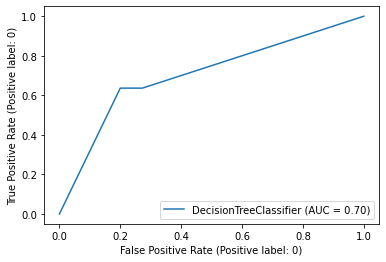

In [7]:
model = DecisionTreeClassifier(random_state=0)

parameter_grid = {'criterion': ['gini', 'entropy'],
            'splitter': ['best', 'random'],
            'max_features': ['sqrt', 'log2'],
            'min_samples_split':  [2, 4, 6, 8],
            'min_samples_leaf':  [1, 2, 4, 6],
            'min_impurity_split': [0.05, 0.1, 0.23, 0.3],
            'class_weight': ["balanced", None]}

dt = grid_search(model, parameter_grid)

## Random Forest

Fitting 5 folds for each of 144 candidates, totalling 720 fits

Best score: 0.9924133118625873
Best parameters: {'criterion': 'entropy', 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
Best estimator: RandomForestClassifier(criterion='entropy', n_estimators=1000, random_state=0)

AUC Score:  0.7950413223140496
Confusion matrix:
[[ 7  4]
 [13 42]]

Classification report:
              precision    recall  f1-score   support

           0       0.35      0.64      0.45        11
           1       0.91      0.76      0.83        55

    accuracy                           0.74        66
   macro avg       0.63      0.70      0.64        66
weighted avg       0.82      0.74      0.77        66




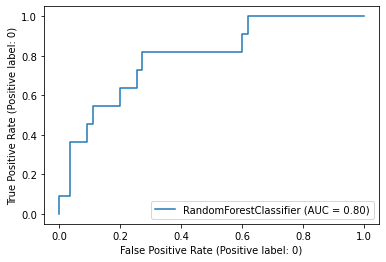

In [8]:
model = RandomForestClassifier(random_state=0)

parameter_grid = {'n_estimators': [1000, 1500, 1800, 2000],
                  'criterion': ['gini', 'entropy'],
                  'min_samples_split': [2, 5, 10],
                  'min_samples_leaf': [1, 2, 4],
                  'max_features': ['auto', None]}

rf = grid_search(model, parameter_grid)

## KNN

Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best score: 0.9564873859366612
Best parameters: {'algorithm': 'ball_tree', 'n_neighbors': 15, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(algorithm='ball_tree', n_neighbors=15, weights='distance')

AUC Score:  0.7818181818181817
Confusion matrix:
[[ 9  2]
 [22 33]]

Classification report:
              precision    recall  f1-score   support

           0       0.29      0.82      0.43        11
           1       0.94      0.60      0.73        55

    accuracy                           0.64        66
   macro avg       0.62      0.71      0.58        66
weighted avg       0.83      0.64      0.68        66




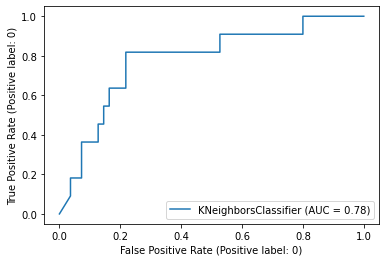

In [9]:
model = KNeighborsClassifier()

parameter_grid = {'n_neighbors': [5, 10, 15],
                  'weights': ['uniform', 'distance'],
                  'algorithm': ['ball_tree', 'kd_tree', 'brute']}

knn = grid_search(model, parameter_grid)

## SVM

Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best score: 0.9885260332796564
Best parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best estimator: SVC(C=100, probability=True, random_state=0)

AUC Score:  0.7900826446280992
Confusion matrix:
[[ 6  5]
 [ 5 50]]

Classification report:
              precision    recall  f1-score   support

           0       0.55      0.55      0.55        11
           1       0.91      0.91      0.91        55

    accuracy                           0.85        66
   macro avg       0.73      0.73      0.73        66
weighted avg       0.85      0.85      0.85        66




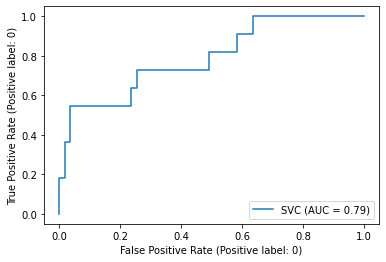

In [10]:
model = SVC(random_state=0, probability=True)

parameter_grid = {'C': [0.1, 1, 10, 100],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma': ['scale', 'auto']}

svm = grid_search(model, parameter_grid)

## AdaBoost


Fitting 5 folds for each of 9 candidates, totalling 45 fits

Best score: 0.9538786902844872
Best parameters: {'learning_rate': 0.5, 'n_estimators': 150}
Best estimator: AdaBoostClassifier(learning_rate=0.5, n_estimators=150, random_state=0)

AUC Score:  0.6628099173553719
Confusion matrix:
[[ 7  4]
 [21 34]]

Classification report:
              precision    recall  f1-score   support

           0       0.25      0.64      0.36        11
           1       0.89      0.62      0.73        55

    accuracy                           0.62        66
   macro avg       0.57      0.63      0.55        66
weighted avg       0.79      0.62      0.67        66




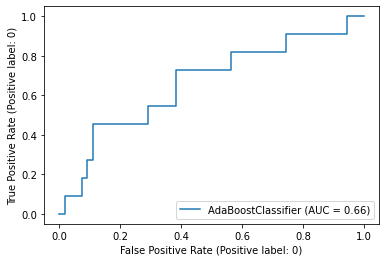

In [11]:
model = AdaBoostClassifier(random_state=0)

parameter_grid = {'n_estimators': [50, 100, 150],
                  'learning_rate': [0.3, 0.5, 1.0]}

ada = grid_search(model, parameter_grid)

## GradientBoost

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


C:\Users\fmna\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.97205797 0.97408481 0.97524852 0.97135802 0.97516479 0.97592915
 0.96924745 0.97342566 0.97380998 0.97533011 0.97882126 0.98115513
 0.97476329 0.98289211 0.98405368 0.9768073  0.97912614 0.98009232
 0.97274289 0.97942029 0.98096618 0.97274289 0.97942029 0.98096618
 0.97505099 0.97873967 0.97874396 0.97205797 0.97408481 0.97524852
 0.97135802 0.97516479 0.97592915 0.96924745 0.97342566 0.97380998
 0.97533011 0.97882126 0.98115513 0.97476329 0.98289211 0.98405368
 0.9768073  0.97912614 0.98009232 0.97274289 0.97942029 0.98096618
 0.97274289 0.97942029 0.98096618 0.97505099 0.97873967 0.97874396
 0.9757402  0.97874181 0.97863017 0.97555341 0.97854214 0.9786409
 0.97622974 0.97835749 0.9773913  0.98038647 0.9828964  0.98376167
 0.9830789  0.98415459 0.98415459 0.98134407 0.98211272 0.98318196
 0.97458293 0.98038433 0.98154589 0.97458293 0.98038433


Best score: 0.9894621578099839
Best parameters: {'criterion': 'friedman_mse', 'learning_rate': 1.0, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best estimator: GradientBoostingClassifier(learning_rate=1.0, max_features='auto',
                           min_samples_leaf=4, random_state=0)

AUC Score:  0.7735537190082645
Confusion matrix:
[[ 7  4]
 [11 44]]

Classification report:
              precision    recall  f1-score   support

           0       0.39      0.64      0.48        11
           1       0.92      0.80      0.85        55

    accuracy                           0.77        66
   macro avg       0.65      0.72      0.67        66
weighted avg       0.83      0.77      0.79        66




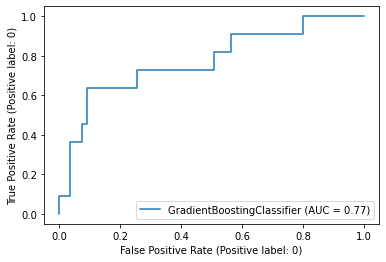

In [12]:
model = GradientBoostingClassifier(random_state=0)

parameter_grid = {'n_estimators': [50, 100, 150],
                  'learning_rate': [0.2, 0.3, 0.5, 1.0],
                  'criterion': ['friedman_mse', 'squared_error'],
                  'min_samples_split': [2, 5, 10],
                  'min_samples_leaf': [1, 2, 4],
                  'max_features': ['auto', None]}

gb = grid_search(model, parameter_grid)

## XGBoost

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best score: 0.9843478260869565
Best parameters: {'alpha': 0.01, 'gamma': 0.01, 'learning_rate': 0.2, 'n_estimators': 300}
Best estimator: XGBClassifier(alpha=0.01, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0.01, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=12,
              num_parallel_tree=1, random_state=0, reg_alpha=0.00999999978,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

AUC Score:  0.8082644628099174
Confusion matrix:
[[ 8  3]
 [16 39]]

Classification report:
              precision    reca

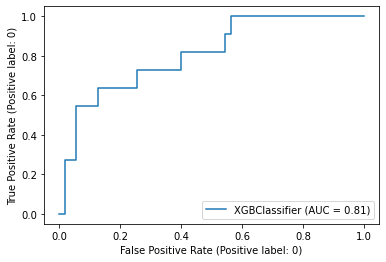

In [13]:
model = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='auc')

parameter_grid = {
    'learning_rate': [0.2, 0.3, 0.5, 1.0],
    'alpha': [0, 0.01, 0.1],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 0.01, 0.1]
}

xgb = grid_search(model, parameter_grid)

# Predictions

In [14]:
x_real = test_data[features]

# change according to model
model = xgb.fit(x, y)
predictions = model.predict_proba(x_real)[:, -1]

In [15]:
submission = pd.DataFrame()
submission['Id'] = test_data['loan_id']
submission['Predicted'] = predictions

submission.to_csv(date.today().strftime("%d-%m-%Y") + '.csv', index=False)

In [16]:
submission

,Id,Predicted
0,4962,0.983563
1,4967,0.132292
2,4968,0.991416
3,4986,0.983563
4,4988,0.984128
...,...,...
349,7279,0.987704
350,7286,0.983563
351,7292,0.983563
352,7294,0.987704
